<img style='float: left' width="150px" src="http://secoora.org/sites/default/files/secoora_logo.png">
<br><br>
## [SECOORA Notebook 1](http://secoora.org/)
### Fetch Sea Surface Salinity time-series data

This notebook fetches weekly time-series of all the SECOORA observations and
models available in the **NGDC** and **SECOORA THREDDS** catalogs.

In [1]:
import time

start_time = time.time()

### Save configuration

In [2]:
import os
try:
    import cPickle as pickle
except ImportError:
    import pickle

import iris
from datetime import datetime
from utilities import CF_names, fetch_range, start_log

# 1-week start of data.
kw = dict(start=datetime(2014, 7, 1, 12), days=6)
start, stop = fetch_range(**kw)

# SECOORA region (NC, SC GA, FL).
bbox = [-87.40, 24.25, -74.70, 36.70]

# CF-names.
sos_name = 'salinity'
name_list = CF_names[sos_name]

# Units.
units = iris.unit.Unit('g/kg')

# Logging.
run_name = '{:%Y-%m-%d}'.format(stop)
log = start_log(start, stop, bbox)

# SECOORA models.
secoora_models = ['SABGOM', 'USEAST',
                  'USF_ROMS', 'USF_SWAN', 'USF_FVCOM']

# Config.
fname = os.path.join(run_name, 'config.pkl')
config = dict(start=start,
              stop=stop,
              bbox=bbox,
              name_list=name_list,
              units=units,
              run_name=run_name,
              secoora_models=secoora_models)

with open(fname,'wb') as f:
    pickle.dump(config, f)

In [3]:
from owslib import fes
from utilities import fes_date_filter

kw = dict(wildCard='*',
          escapeChar='\\',
          singleChar='?',
          propertyname='apiso:AnyText')

or_filt = fes.Or([fes.PropertyIsLike(literal=('*%s*' % val), **kw)
                  for val in name_list])

# Exclude ROMS Averages and History files.
not_filt = fes.Not([fes.PropertyIsLike(literal='*Averages*', **kw)])

begin, end = fes_date_filter(start, stop)
filter_list = [fes.And([fes.BBox(bbox), begin, end, or_filt, not_filt])]

In [4]:
from owslib.csw import CatalogueServiceWeb

endpoint = 'http://www.ngdc.noaa.gov/geoportal/csw'
csw = CatalogueServiceWeb(endpoint, timeout=60)
csw.getrecords2(constraints=filter_list, maxrecords=1000, esn='full')

fmt = '{:*^64}'.format
log.info(fmt(' Catalog information '))
log.info("URL: {}".format(endpoint))
log.info("CSW version: {}".format(csw.version))
log.info("Number of datasets available: {}".format(len(csw.records.keys())))

In [5]:
from utilities import service_urls

dap_urls = service_urls(csw.records, service='odp:url')
sos_urls = service_urls(csw.records, service='sos:url')

log.info(fmt(' CSW '))
for rec, item in csw.records.items():
    log.info('{}'.format(item.title))

log.info(fmt(' SOS '))
for url in sos_urls:
    log.info('{}'.format(url))

log.info(fmt(' DAP '))
for url in dap_urls:
    log.info('{}.html'.format(url))

In [6]:
from utilities import is_station

# Filter out some observations (stations) endpoints from the models list.
non_stations = []
for url in dap_urls:
    try:
        if not is_station(url):
            non_stations.append(url)
    except RuntimeError as e:
        log.warn("Could not access URL {}. {!r}".format(url, e))

dap_urls = non_stations

log.info(fmt(' Filtered DAP '))
for url in dap_urls:
    log.info('{}.html'.format(url))

### Add SECOORA models and observations

In [7]:
from utilities import titles, fix_url

for secoora_model in secoora_models:
    if titles[secoora_model] not in dap_urls:
        log.warning('{} not in the NGDC csw'.format(secoora_model))
        dap_urls.append(titles[secoora_model])

# NOTE: USEAST is not archived at the moment!
# https://github.com/ioos/secoora/issues/173
dap_urls = [fix_url(start, url) if
            'SABGOM' in url else url for url in dap_urls]

In [8]:
import warnings
from iris.exceptions import CoordinateNotFoundError, ConstraintMismatchError

from utilities import (TimeoutException, secoora_buoys,
                       quick_load_cubes, proc_cube)

urls = list(secoora_buoys())
buoys = dict()
if not urls:
    raise ValueError("Did not find any SECOORA buoys!")

for url in urls:
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")  # Suppress iris warnings.
            kw = dict(bbox=bbox, time=(start, stop), units=units)
            cubes = quick_load_cubes(url, name_list)
            cubes = [proc_cube(cube, **kw) for cube in cubes]
        buoy = url.split('/')[-1].split('.nc')[0]
        if len(cubes) == 1:
            buoys.update({buoy: cubes[0]})
        else:
            #[buoys.update({'{}_{}'.format(buoy, k): cube}) for
            # k, cube in list(enumerate(cubes))]
            # FIXME: For now I am choosing the first sensor.
            buoys.update({buoy: cubes[0]})
    except (RuntimeError, ValueError, TimeoutException,
            ConstraintMismatchError, CoordinateNotFoundError) as e:
        log.warning('Cannot get cube for: {}\n{}'.format(url, e))

In [9]:
from pyoos.collectors.coops.coops_sos import CoopsSos

collector = CoopsSos()

collector.end_time = stop
collector.start_time = start
collector.variables = [sos_name]

ofrs = collector.server.offerings
title = collector.server.identification.title
log.info(fmt(' Collector offerings '))
log.info('{}: {} offerings'.format(title, len(ofrs)))

In [10]:
from pandas import read_csv
from utilities import sos_request

params = dict(observedProperty=sos_name,
              eventTime=start.strftime('%Y-%m-%dT%H:%M:%SZ'),
              featureOfInterest='BBOX:{0},{1},{2},{3}'.format(*bbox),
              offering='urn:ioos:network:NOAA.NOS.CO-OPS:MetActive')

uri = 'http://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS'
url = sos_request(uri, **params)
observations = read_csv(url)

log.info('SOS URL request: {}'.format(url))

### Clean the DataFrame

In [11]:
from utilities import get_coops_metadata, to_html

columns = {'sensor_id': 'sensor',
           'station_id': 'station',
           'latitude (degree)': 'lat',
           'longitude (degree)': 'lon',
           'sea_water_salinity (psu)': sos_name}

observations.rename(columns=columns, inplace=True)

observations['sensor'] = [s.split(':')[-1] for s in observations['sensor']]
observations['station'] = [s.split(':')[-1] for s in observations['station']]
observations['name'] = [get_coops_metadata(s)[0] for s in observations['station']]

observations.set_index('name', inplace=True)
to_html(observations.head())

,station,sensor,lat,lon,date_time,salinity
name,,,,,,
"Dames Point, FL",8720219,SALINITY,30.3867,-81.5583,2014-07-01T12:00:00Z,23.79
"Jacksonville University, FL",8720245,SALINITY,30.3541,-81.6118,2014-07-01T12:00:00Z,21.81
"I-295 Bridge, St Johns River, FL",8720357,SALINITY,30.1917,-81.6917,2014-07-01T12:00:00Z,4.61
"Red Bay Point, St Johns River, FL",8720503,SALINITY,29.9783,-81.6283,2014-07-01T12:00:00Z,0.56
"Racy Point, St Johns River, FL",8720625,SALINITY,29.8017,-81.5483,2014-07-01T12:00:00Z,0.44


In [12]:
from pandas import DataFrame
from utilities import secoora2df

if buoys:
    secoora_observations = secoora2df(buoys, sos_name)
    to_html(secoora_observations.head())
else:
    secoora_observations = DataFrame()

In [13]:
from pandas import concat

all_obs = concat([observations, secoora_observations], axis=0)
to_html(concat([all_obs.head(2), all_obs.tail(2)]))

,station,sensor,lat,lon,date_time,salinity
name,,,,,,
"Dames Point, FL",8720219,SALINITY,30.38670,-81.558300,2014-07-01T12:00:00Z,23.790000
"Jacksonville University, FL",8720245,SALINITY,30.35410,-81.611800,2014-07-01T12:00:00Z,21.810000
"CAROCOOPS FRP2, Fripp Nearshore, SC",carocoops.frp2.buoy,NA,32.27000,-80.400002,2014-00-01T12:00:00Z,34.264256
"Apache Pier, Myrtle Beach, SC",lbhmc.apachepier.pier,NA,33.76152,-78.779877,2014-00-01T12:00:00Z,-45.022461


### Uniform 6-min time base for model/data comparison

In [14]:
from owslib.ows import ExceptionReport
from utilities import pyoos2df, save_timeseries

iris.FUTURE.netcdf_promote = True

log.info(fmt(' Observations '))
outfile = '{:%Y-%m-%d}-OBS_DATA.nc'.format(stop)
outfile = os.path.join(run_name, outfile)

log.info(fmt(' Downloading to file {} '.format(outfile)))
data, bad_station = dict(), []
col = 'sea_water_salinity (psu)'
for station in observations.index:
    station_code = observations['station'][station]
    try:
        df = pyoos2df(collector, station_code, df_name=station)
        data.update({station_code: df[col]})
    except ExceptionReport as e:
        bad_station.append(station_code)
        log.warning("[{}] {}:\n{}".format(station_code, station, e))
obs_data = DataFrame.from_dict(data)

### Split good and bad stations

In [15]:
pattern = '|'.join(bad_station)
if pattern:
    all_obs['bad_station'] = all_obs.station.str.contains(pattern)
    observations = observations[~observations.station.str.contains(pattern)]
else:
    all_obs['bad_station'] = ~all_obs.station.str.contains(pattern)

# Save updated `all_obs.csv`.
fname = '{}-all_obs.csv'.format(run_name)
fname = os.path.join(run_name, fname)
all_obs.to_csv(fname)

log.info(fmt(' Downloading to file {} '.format(outfile)))
comment = "Several stations from http://opendap.co-ops.nos.noaa.gov"
kw = dict(longitude=observations.lon,
          latitude=observations.lat,
          station_attr=dict(cf_role="timeseries_id"),
          cube_attr=dict(featureType='timeSeries',
                         Conventions='CF-1.6',
                         standard_name_vocabulary='CF-1.6',
                         cdm_data_type="Station",
                         comment=comment,
                         url=url))

save_timeseries(obs_data, outfile=outfile,
                standard_name=sos_name, **kw)

### SECOORA Observations

In [16]:
import numpy as np
from pandas import DataFrame


def extract_series(cube, station):
    time = cube.coord(axis='T')
    date_time = time.units.num2date(cube.coord(axis='T').points)
    data = cube.data
    return DataFrame(data, columns=[station], index=date_time)


if buoys:
    secoora_obs_data = []
    for station, cube in list(buoys.items()):
        df = extract_series(cube, station)
        secoora_obs_data.append(df)
    # Some series have duplicated times!
    kw = dict(subset='index', take_last=True)
    secoora_obs_data = [obs.reset_index().drop_duplicates(**kw).set_index('index') for
                        obs in secoora_obs_data]
    secoora_obs_data = concat(secoora_obs_data, axis=1)
else:
    secoora_obs_data = DataFrame()

### These buoys need some QA/QC before saving

In [17]:
from utilities.qaqc import filter_spikes, threshold_series

if buoys:
    secoora_obs_data.apply(threshold_series, args=(0, 40))
    secoora_obs_data.apply(filter_spikes)

    # Interpolate to the same index as SOS.
    index = obs_data.index
    kw = dict(method='time', limit=30)
    secoora_obs_data = secoora_obs_data.reindex(index).interpolate(**kw).ix[index]

    log.info(fmt(' SECOORA Observations '))
    fname = '{:%Y-%m-%d}-SECOORA_OBS_DATA.nc'.format(stop)
    fname = os.path.join(run_name, fname)

    log.info(fmt(' Downloading to file {} '.format(fname)))

    url = "http://129.252.139.124/thredds/catalog_platforms.html"
    comment = "Several stations {}".format(url)
    kw = dict(longitude=secoora_observations.lon,
              latitude=secoora_observations.lat,
              station_attr=dict(cf_role="timeseries_id"),
              cube_attr=dict(featureType='timeSeries',
                             Conventions='CF-1.6',
                             standard_name_vocabulary='CF-1.6',
                             cdm_data_type="Station",
                             comment=comment,
                             url=url))

    save_timeseries(secoora_obs_data, outfile=fname,
                    standard_name=sos_name, **kw)

    to_html(secoora_obs_data.head())

### Loop discovered models and save the nearest time-series

In [18]:
from iris.exceptions import (CoordinateNotFoundError, ConstraintMismatchError,
                             MergeError)

from utilities import time_limit, is_model, get_model_name, get_surface


log.info(fmt(' Models '))
cubes = dict()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")  # Suppress iris warnings.
    for k, url in enumerate(dap_urls):
        log.info('\n[Reading url {}/{}]: {}'.format(k+1, len(dap_urls), url))
        try:
            with time_limit(60*5):
                cube = quick_load_cubes(url, name_list, callback=None, strict=True)
                if is_model(cube):
                    cube = proc_cube(cube, bbox=bbox, time=(start, stop), units=units)
                else:
                    log.warning("[Not model data]: {}".format(url))
                    continue
                cube = get_surface(cube)
                mod_name, model_full_name = get_model_name(cube, url)
                cubes.update({mod_name: cube})
        except (TimeoutException, RuntimeError, ValueError,
                ConstraintMismatchError, CoordinateNotFoundError,
                IndexError) as e:
            log.warning('Cannot get cube for: {}\n{}'.format(url, e))

Exception AttributeError: "'CFReader' object has no attribute '_dataset'" in <bound method CFReader.__del__ of CFReader('http://omgarch1.meas.ncsu.edu:8080/thredds/dodsC/fmrc/sabgom/SABGOM_Forecast_Model_Run_Collection_best.ncd')> ignored


In [19]:
from iris.pandas import as_series

from utilities import (make_tree, get_nearest_water,
                       add_station, ensure_timeseries, remove_ssh)

for mod_name, cube in cubes.items():
    fname = '{:%Y-%m-%d}-{}.nc'.format(stop, mod_name)
    fname = os.path.join(run_name, fname)
    log.info(fmt(' Downloading to file {} '.format(fname)))
    try:
        tree, lon, lat = make_tree(cube)
    except CoordinateNotFoundError as e:
        log.warning('Cannot make KDTree for: {}'.format(mod_name))
        continue
    # Get model series at observed locations.
    raw_series = dict()
    for station, obs in all_obs.iterrows():
        try:
            kw = dict(k=10, max_dist=0.04, min_var=0.01)
            args = cube, tree, obs.lon, obs.lat
            series, dist, idx = get_nearest_water(*args, **kw)
        except ValueError as e:
            status = "No Data"
            log.info('[{}] {}'.format(status, obs.name))
            continue
        except RuntimeError as e:
            status = "Failed"
            log.info('[{}] {}. ({})'.format(status, obs.name, e.message))
            continue
        if not series:
            status = "Land   "
        else:
            raw_series.update({obs['station']: series})
            series = as_series(series)
            status = "Water  "

        log.info('[{}] {}'.format(status, obs.name))

    if raw_series:  # Save cube.
        for station, cube in raw_series.items():
            cube = add_station(cube, station)
            cube = remove_ssh(cube)
        try:
            cube = iris.cube.CubeList(raw_series.values()).merge_cube()
        except MergeError as e:
            log.warning(e)

        ensure_timeseries(cube)
        iris.save(cube, fname)
        del cube

    log.info(fmt('Finished processing {}\n'.format(mod_name)))

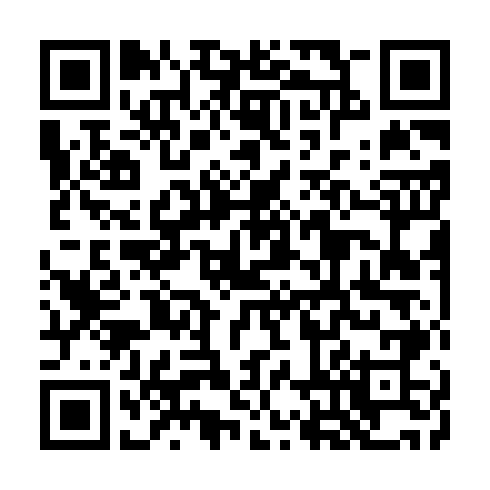

In [20]:
from utilities import nbviewer_link, make_qr

make_qr(nbviewer_link('00-fetch_data.ipynb'))

In [21]:
elapsed = time.time() - start_time
log.info('{:.2f} minutes'.format(elapsed/60.))
log.info('EOF')

with open('{}/log.txt'.format(run_name)) as f:
    print(f.read())

02:23:28 INFO: ************Saving data inside directory 2014-07-07*************
02:23:28 INFO: *********************** Run information ************************
02:23:28 INFO: Run date: 2015-11-24 17:23:28
02:23:28 INFO: Download start: 2014-07-01 12:00:00
02:23:28 INFO: Download stop: 2014-07-07 12:00:00
02:23:28 INFO: Bounding box: -87.40, 24.25,-74.70, 36.70
02:23:28 INFO: *********************** Software version ***********************
02:23:28 INFO: Iris version: 1.8.1
02:23:28 INFO: owslib version: 0.10.0
02:23:28 INFO: pyoos version: 0.6.2
02:23:32 INFO: ********************* Catalog information **********************
02:23:32 INFO: URL: http://www.ngdc.noaa.gov/geoportal/csw
02:23:32 INFO: CSW version: 2.0.2
02:23:32 INFO: Number of datasets available: 31
02:23:32 INFO: ***************************** CSW ******************************
02:23:32 INFO: USF FVCOM - Nowcast Aggregation
02:23:32 INFO: ROMS/TOMS 3.0 - South-Atlantic Bight and Gulf of Mexico
02:23:32 INFO: COAWST Forecas